In [1]:
import re
from typing import List
from itertools import chain, islice
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for classical machine learning
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
                                    GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            f1_score, accuracy_score, roc_auc_score, \
                            precision_score, recall_score

# Libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
# unfortunately the functions below aren't available.
# GitHub (as of 3rd Nov. 2024): https://github.com/pytorch/text/issues/2272
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator

from faiq_utils import make_confusion_matrix

%matplotlib inline

### 1.0 Load cleaned lemmatized dataset

In [2]:
# Read the clean dataset
reviews = pd.read_csv('../data/clean_train_lemma.csv')

In [3]:
# View the first 5 rows of our dataset
reviews.head()

,content,content_lemma,score,target
0,My game was great! I play it on the pc too! Bu...,pc since recent update work phone samsung e wo...,3,1
1,This game is awesome but my phone doesn't have...,awesome phone storage long lastly delete soon,3,1
2,Your game is great I like the way you can tell...,way tell region based buy use real people whit...,2,1
3,I've been playing this game for more than a ye...,year say addictive reason gave star login suck...,1,1
4,Maybe get it if you can't play breath of the w...,maybe get breath wild feels bland otherwise co...,2,1


In [4]:
# 6472 documents in our dataset
reviews.shape

(6472, 4)

In [5]:
# Check the data types
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6472 entries, 0 to 6471
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        6472 non-null   object
 1   content_lemma  6472 non-null   object
 2   score          6472 non-null   int64 
 3   target         6472 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 202.4+ KB


In [6]:
# Establish our baseline score
reviews['target'].value_counts(normalize=True)

target
1    0.601978
0    0.398022
Name: proportion, dtype: float64

Given that the majority class is class 1 (negative reviews), our **baseline score** is an accuracy of **0.60**. The baseline score will serve as a point of comparison when evaluating our models.

In [8]:
X = reviews['content_lemma']
y = reviews['target']

In [9]:
# Perform train test split so that we can train, score and tune our models' hyperparameters 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [10]:
X_train.shape

(5177,)

In [11]:
X_test.shape

(1295,)

In [12]:
y_train.value_counts(normalize=True)

target
1    0.601893
0    0.398107
Name: proportion, dtype: float64

In [13]:
y_test.value_counts(normalize=True)

target
1    0.602317
0    0.397683
Name: proportion, dtype: float64

We'll now use the CountVectorizer() to check how many unique words there are. Overall, there are 6023 words in our corpus. When we add bi-grams into the picture, we have 72975 uni/bi-grams in total (which is too much!).

In [14]:
cvec_1 = CountVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
cvec_1_df = pd.DataFrame(cvec_1.fit_transform(X_train).todense(), columns=cvec_1.get_feature_names_out())

cvec_1_df.shape

(5177, 8831)

In [15]:
cvec_2 = CountVectorizer(stop_words = 'english', ngram_range=(1, 2)) 
cvec_2_df = pd.DataFrame(cvec_2.fit_transform(X_train).todense(), columns=cvec_2.get_feature_names_out())

cvec_2_df.shape

(5177, 80043)

### 2.0 Modeling

Here, we will only explore classical machine learning for sentiment analysis on the lemmatized dataset.

#### 2.1 Classical Machine Learning

We will use the Bag of Words (BoW) representation to extract features from the text. This will be done through vectorization, specifically the CountVectorizer and TF-IDF Vectorizer. The CountVectorizer simply tokenizes and counts the word occurrences in our corpus. While on the other hand, TF-IDF tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

After vectorizing, we will fit a Logistic Regression, Naive Bayes and Support Vector Machine on the training data and evaluate the models' performance on the validation set.

##### 2.1.1 Count Vectorizer & Logistic Regression

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 300, 'cvec__min_df': 20, 'cvec__ngram_range': (1, 1), 'lr__C': 0.1, 'lr__penalty': 'l2'}
Best CV score:  0.7322838173902004
Training score: 0.7614448522310219
Validation score: 0.7250965250965251

              precision    recall  f1-score   support

           0       0.71      0.52      0.60       515
           1       0.73      0.86      0.79       780

    accuracy                           0.73      1295
   macro avg       0.72      0.69      0.70      1295
weighted avg       0.72      0.73      0.72      1295



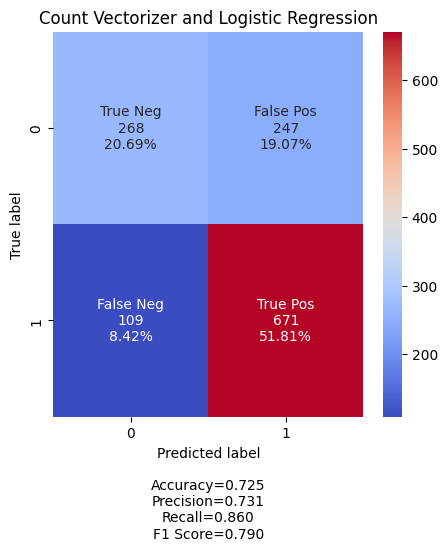

In [16]:
# Create a pipeline with Count Vectorizer and Logistic Regression
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_lr_params = {
    'cvec__max_features': [300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1), (1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01,.1]
}

# Instantiate GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, # Objects to optimise
                          param_grid = pipe_cvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
cvec_lr_pred = gs_cvec_lr.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_cvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_lr.best_score_)
print('Training score:', gs_cvec_lr.score(X_train, y_train))
print('Validation score:', gs_cvec_lr.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_lr_pred))

cm_gd = confusion_matrix(y_test, cvec_lr_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'], 
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer and Logistic Regression"
)

##### 2.1.2 TF-IDF Vectorizer & Logistic Regression

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 300, 'tvec__min_df': 20, 'tvec__ngram_range': (1, 1)}
Best CV score:  0.736921129474321
Training score: 0.7649217693644969
Validation score: 0.7281853281853282

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       515
           1       0.74      0.86      0.79       780

    accuracy                           0.73      1295
   macro avg       0.72      0.70      0.70      1295
weighted avg       0.73      0.73      0.72      1295



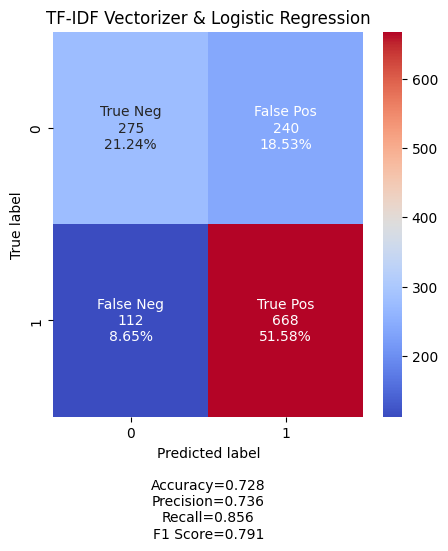

In [17]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50],
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [.01, .1, 1]
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_lr_pred))

cm_gd = confusion_matrix(y_test, tvec_lr_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "TF-IDF Vectorizer & Logistic Regression"
)

##### 2.1.3 Count Vectorizer & Naive Bayes

Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 500, 'cvec__min_df': 10, 'cvec__ngram_range': (1, 1)}
Best CV score:  0.725515485089953
Training score: 0.7488893181379177
Validation score: 0.7266409266409266

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       515
           1       0.77      0.78      0.77       780

    accuracy                           0.73      1295
   macro avg       0.71      0.71      0.71      1295
weighted avg       0.73      0.73      0.73      1295



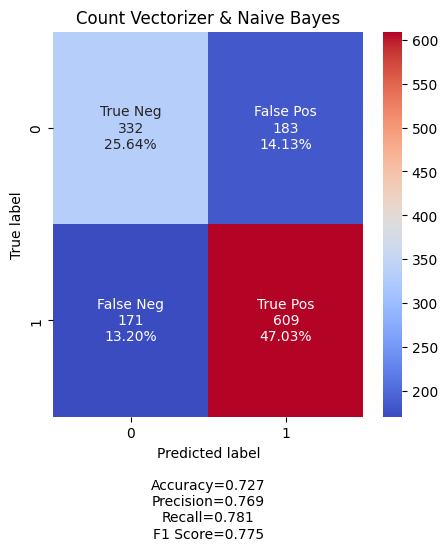

In [18]:
# Create a pipeline with Count Vectorizer and Naive Bayes
pipe_cvec_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_cvec_nb_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50],
    'cvec__max_df': [.9,.95], 
    'cvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, # Objects to optimise
                          param_grid = pipe_cvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_cvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_nb_pred = gs_cvec_nb.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_cvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_nb.best_score_)
print('Training score:', gs_cvec_nb.score(X_train, y_train))
print('Validation score:', gs_cvec_nb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_nb_pred))

cm_gd = confusion_matrix(y_test, cvec_nb_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer & Naive Bayes"
)

##### 2.1.4 TF-IDF Vectorizer & Naive Bayes

Best parameters:  {'tvec__max_df': 0.9, 'tvec__max_features': 400, 'tvec__min_df': 20, 'tvec__ngram_range': (1, 1)}
Best CV score:  0.7386552205701141
Training score: 0.755456828278926
Validation score: 0.7281853281853282

              precision    recall  f1-score   support

           0       0.73      0.50      0.59       515
           1       0.73      0.88      0.80       780

    accuracy                           0.73      1295
   macro avg       0.73      0.69      0.69      1295
weighted avg       0.73      0.73      0.72      1295



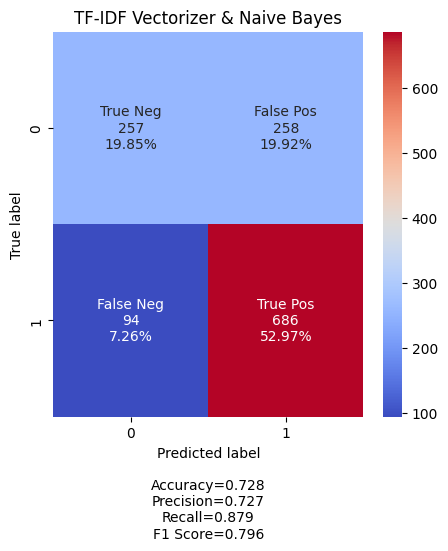

In [19]:
# Create a pipeline with TF-IDF and Naive Bayes
pipe_tvec_nb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

# Search over the following values of hyperparameters:
pipe_tvec_nb_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50],
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
}

# Instantiate GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, # Objects to optimise
                          param_grid = pipe_tvec_nb_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_nb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_nb_pred = gs_tvec_nb.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_tvec_nb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_nb.best_score_)
print('Training score:', gs_tvec_nb.score(X_train, y_train))
print('Validation score:', gs_tvec_nb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_nb_pred))

cm_gd = confusion_matrix(y_test, tvec_nb_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "TF-IDF Vectorizer & Naive Bayes"
)

##### 2.1.5 Count Vectorizer & SVC

Best parameters:  {'svc__kernel': 'linear', 'svc__degree': 3, 'svc__C': 0.1, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 2, 'cvec__max_features': 400, 'cvec__max_df': 0.9}
Best CV score:  0.7234008946774904
Training score: 0.7641491211126135
Validation score: 0.7204633204633205

              precision    recall  f1-score   support

           0       0.72      0.48      0.58       515
           1       0.72      0.88      0.79       780

    accuracy                           0.72      1295
   macro avg       0.72      0.68      0.68      1295
weighted avg       0.72      0.72      0.71      1295



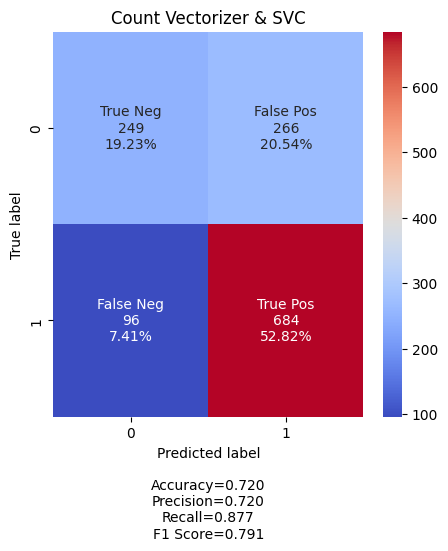

In [20]:
# Create a pipeline with Count Vectorizer and SVC
pipe_cvec_svc = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', SVC(random_state=42))
])

# Search over the following values of hyperparameters:
pipe_cvec_svc_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [2, 3], 
    'cvec__max_df': [.9, .95], 
    'cvec__ngram_range':[(1,1), (1,2)],  
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [3],
    'svc__C': [.1, .01]
}

# Instantiate RandomizedSearchCV
gs_cvec_svc = RandomizedSearchCV(
                    pipe_cvec_svc, # Objects to optimise
                    param_distributions = pipe_cvec_svc_params, # Hyperparameters for tuning
                    cv=10,
                    n_iter=5,
                    random_state=42,
                ) # 10-fold cross validation

# Fit model on to training data
gs_cvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
cvec_svc_pred = gs_cvec_svc.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_cvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_svc.best_score_)
print('Training score:', gs_cvec_svc.score(X_train, y_train))
print('Validation score:', gs_cvec_svc.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_svc_pred))

cm_gd = confusion_matrix(y_test, cvec_svc_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Count Vectorizer & SVC"
)

##### 2.1.6 TF-IDF Vectorizer & SVC

Best parameters:  {'tvec__ngram_range': (1, 1), 'tvec__min_df': 3, 'tvec__max_features': 400, 'tvec__max_df': 0.9, 'svc__kernel': 'linear', 'svc__degree': 3, 'svc__C': 0.1}
Best CV score:  0.7249419355802335
Training score: 0.7374927564226386
Validation score: 0.715057915057915

              precision    recall  f1-score   support

           0       0.79      0.39      0.52       515
           1       0.70      0.93      0.80       780

    accuracy                           0.72      1295
   macro avg       0.74      0.66      0.66      1295
weighted avg       0.73      0.72      0.69      1295



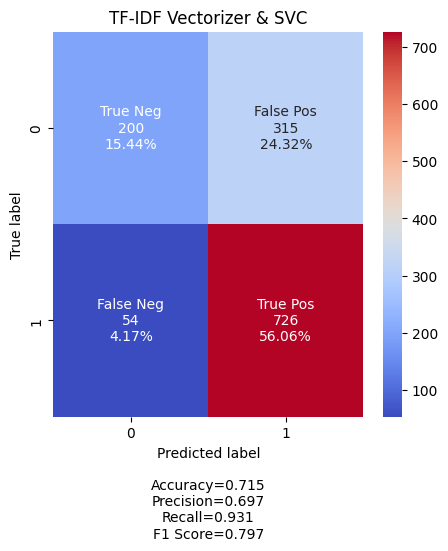

In [21]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC(probability=True, random_state=42)) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [2,3], 
    'tvec__max_df': [.9,.95], 
    'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__degree': [3],
    'svc__C': [.1, .01]
}

# Instantiate RandomizedSearchCV
gs_tvec_svc = RandomizedSearchCV(
                        pipe_tvec_svc, # Objects to optimise
                        param_distributions = pipe_tvec_svc_params, # Hyperparameters for tuning
                        cv=10,
                        n_iter=5,
                        random_state=42,
                ) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_svc_pred))

cm_gd = confusion_matrix(y_test, tvec_svc_pred)
make_confusion_matrix(
    cm_gd, 
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "TF-IDF Vectorizer & SVC"
)

##### 2.1.7 Voting Classifier (Logistic Regression & Naive Bayes)

Given that the Logistic Regression and SVC are rather different algorithms, we will use ensemble learning in an attempt to improve our model's accuracy and recall. We will use a Voting Classifier where the winning class will be determined by soft voting. As the Naive Bayes returned a better recall rate than the Logistic Regression, we will give a higher voting weight to the Naive Bayes than the Logistic Regression.

Training score: 0.762410662545876
Validation score: 0.7297297297297297

              precision    recall  f1-score   support

           0       0.67      0.62      0.65       515
           1       0.76      0.80      0.78       780

    accuracy                           0.73      1295
   macro avg       0.72      0.71      0.71      1295
weighted avg       0.73      0.73      0.73      1295



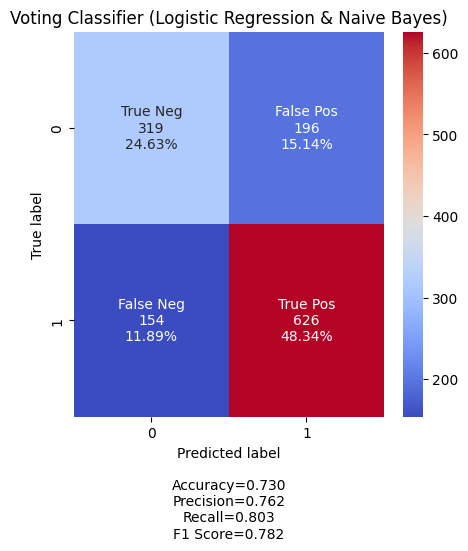

In [22]:
# Instantiate the Voting Classifier with TF-IDF Logistic Regression and SVC
voting_clf = VotingClassifier(
    estimators=[('tvec_lr', gs_tvec_lr),
                ('cvec_nb', gs_cvec_nb)],
    voting='soft',
    weights=[1.5, 2]
)

# Fit model on to training data
voting_clf.fit(X_train, y_train)

# Generate predictions on validation set
voting_pred = voting_clf.predict(X_test)

# Print accuracy scores
print('Training score:', voting_clf.score(X_train, y_train))
print('Validation score:', voting_clf.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, voting_pred))

cm_gd = confusion_matrix(y_test, voting_pred)
make_confusion_matrix(
    cm_gd,
    group_names = ['True Neg','False Pos','False Neg','True Pos'],
    categories = ['0', '1'],
    cmap = 'coolwarm',
    figsize = (5,5),
    title = "Voting Classifier (Logistic Regression & Naive Bayes)"
)

##### 2.1.7 Count Vectorizer & XgBoost

Best parameters:  {'xgb__subsample': 0.8, 'xgb__n_estimators': 500, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.8, 'cvec__ngram_range': (1, 2), 'cvec__min_df': 30, 'cvec__max_features': 400, 'cvec__max_df': 0.95}
Best CV score:  0.7305452454388625
Training score: 0.8170755263666216
Validation score: 0.7266409266409266

              precision    recall  f1-score   support

           0       0.71      0.53      0.61       515
           1       0.74      0.85      0.79       780

    accuracy                           0.73      1295
   macro avg       0.72      0.69      0.70      1295
weighted avg       0.72      0.73      0.72      1295



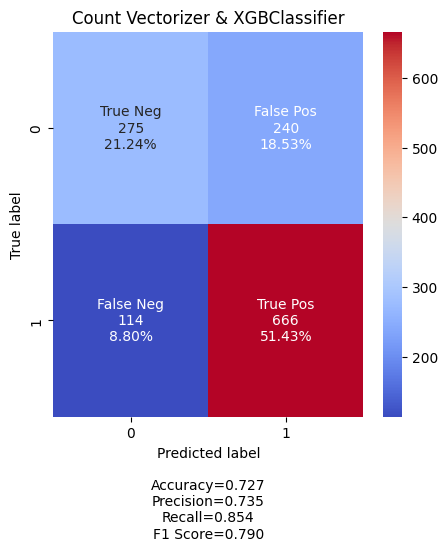

In [23]:
# Create a pipeline with CountVectorizer and XGBClassifier
pipe_cvec_xgb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Define hyperparameters for RandomizedSearchCV
pipe_cvec_xgb_params = {
    'cvec__max_features': [500, 400, 300, 200, 100],
    'cvec__min_df': [10, 20, 30, 40, 50], 
    'cvec__max_df': [0.9, 0.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [500, 750, 1000],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.1, 0.01, 0.05],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0]
}

# Instantiate RandomizedSearchCV
gs_cvec_xgb = RandomizedSearchCV(
                pipe_cvec_xgb,  # Pipeline to optimize
                param_distributions=pipe_cvec_xgb_params,  # Hyperparameters for tuning
                cv=10, 
                n_iter=5,  # Number of parameter settings that are sampled
                random_state=42
            )

# Fit model on to training data
gs_cvec_xgb.fit(X_train, y_train)

# Generate predictions on validation set
cvec_xgb_pred = gs_cvec_xgb.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_cvec_xgb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_cvec_xgb.best_score_)
print('Training score:', gs_cvec_xgb.score(X_train, y_train))
print('Validation score:', gs_cvec_xgb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, cvec_xgb_pred))

cm_gd = confusion_matrix(y_test, cvec_xgb_pred)
make_confusion_matrix(
    cm_gd, 
    group_names=['True Neg', 'False Pos', 'False Neg', 'True Pos'],
    categories=['0', '1'],
    cmap='coolwarm',
    figsize=(5, 5),
    title="Count Vectorizer & XGBClassifier"
)


Thresholding doesn't seem to yield much improvement.

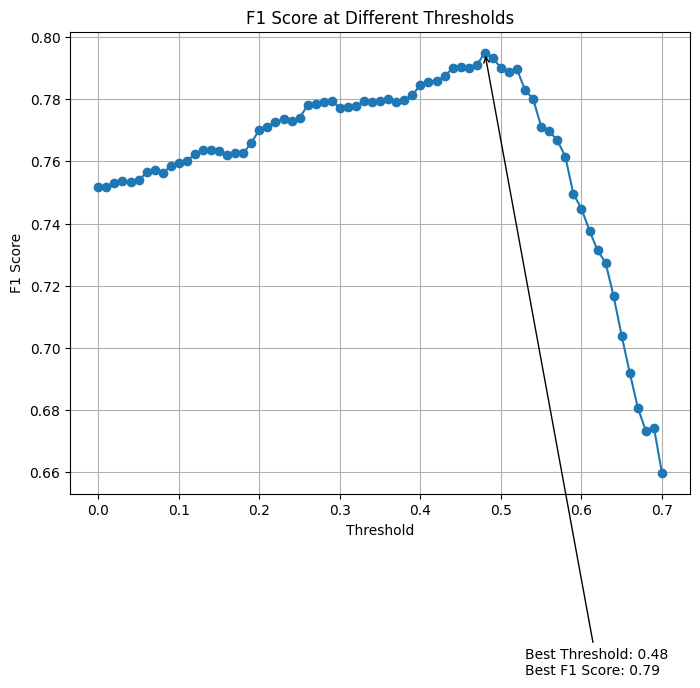

Best Threshold:  0.48
Acc Score:  0.7281853281853282
Roc Auc Score:  0.6905775454319143
Precision Score:  0.7286324786324786
Recall Score:  0.8743589743589744
f1 score:  0.7948717948717948
LightGBM confusion matrix on test data  
 [[261 254]
 [ 98 682]]
_____________________________________________________

Classification Report  on test data 
              precision    recall  f1-score   support

           0       0.73      0.51      0.60       515
           1       0.73      0.87      0.79       780

    accuracy                           0.73      1295
   macro avg       0.73      0.69      0.70      1295
weighted avg       0.73      0.73      0.72      1295

_____________________________________________________



In [25]:
# Obtain the predicted probabilities for each class on the test set
probs=gs_cvec_xgb.predict_proba(X_test)

# Define a range of threshold values to try
thresholds = np.arange(0, 0.71, 0.01)

# Initialize variables to store F1 scores
f1_scores = []

# Iterate over the threshold values and evaluate the model's performance
for threshold in thresholds:
    preds = (probs[:, 1] > threshold).astype(int)
    score = f1_score(y_test, preds)
    f1_scores.append(score)

# Find the best threshold and its corresponding F1 score
best_threshold = thresholds[np.argmax(f1_scores)]
best_score = max(f1_scores)

# Plot the F1 scores at different thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o')
plt.title("F1 Score at Different Thresholds")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.grid(True)

# Mark the best threshold on the chart
plt.annotate(f"Best Threshold: {best_threshold:.2f}\nBest F1 Score: {best_score:.2f}",
             xy=(best_threshold, best_score),
             xytext=(best_threshold + 0.05, best_score - 0.2),
             arrowprops=dict(arrowstyle='->'))

# Show the plot
plt.show()

# Use the best threshold to predict the test set and evaluate the model's performance
preds2 = (gs_cvec_xgb.predict_proba(X_test)[:,1] > best_threshold).astype(int)

print('Best Threshold: ', best_threshold)
print('Acc Score: ', accuracy_score(y_test, preds2))
print('Roc Auc Score: ', roc_auc_score(y_test, preds2))
print('Precision Score: ', precision_score(y_test, preds2))
print('Recall Score: ', recall_score(y_test, preds2))
print('f1 score: ', f1_score(y_test, preds2))
print('LightGBM confusion matrix on test data  \n', confusion_matrix(y_test, preds2) )
print('_____________________________________________________')
print("")
print('Classification Report  on test data ')
print(classification_report(y_test, preds2))
print('_____________________________________________________')
print("")

##### 2.1.8 TF-IDF Vectorizer & XgBoost

Best parameters:  {'xgb__subsample': 0.8, 'xgb__n_estimators': 500, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.8, 'tvec__ngram_range': (1, 2), 'tvec__min_df': 30, 'tvec__max_features': 400, 'tvec__max_df': 0.95}
Best CV score:  0.730544498629605
Training score: 0.8383233532934131
Validation score: 0.7297297297297297

              precision    recall  f1-score   support

           0       0.73      0.51      0.60       515
           1       0.73      0.87      0.80       780

    accuracy                           0.73      1295
   macro avg       0.73      0.69      0.70      1295
weighted avg       0.73      0.73      0.72      1295



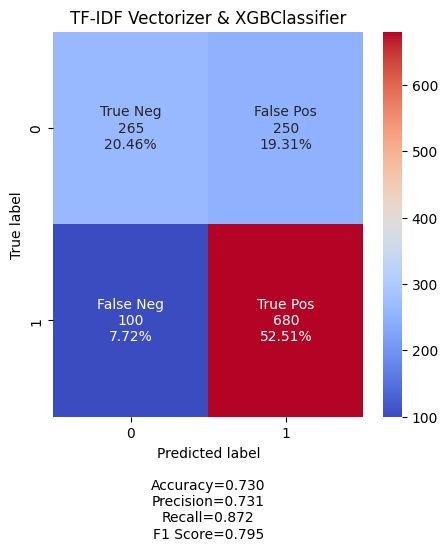

In [24]:
# Create a pipeline with TF-IDF Vectorizer and XGBClassifier
pipe_tvec_xgb = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(objective='binary:logistic', random_state=42))
])

# Define hyperparameters for RandomizedSearchCV
pipe_tvec_xgb_params = {
    'tvec__max_features': [500, 400, 300, 200, 100],
    'tvec__min_df': [10, 20, 30, 40, 50], 
    'tvec__max_df': [0.9, 0.95], 
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [500, 750, 1000],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.1, 0.01, 0.05],
    'xgb__subsample': [0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.8, 0.9, 1.0]
}

# Instantiate RandomizedSearchCV
gs_tvec_xgb = RandomizedSearchCV(
                pipe_tvec_xgb,  # Pipeline to optimize
                param_distributions=pipe_tvec_xgb_params,  # Hyperparameters for tuning
                cv=10, 
                n_iter=5,  # Number of parameter settings that are sampled
                random_state=42
            )

# Fit model on to training data
gs_tvec_xgb.fit(X_train, y_train)

# Generate predictions on validation set
tvec_xgb_pred = gs_tvec_xgb.predict(X_test)

# Print best parameters
print('Best parameters: ', gs_tvec_xgb.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_xgb.best_score_)
print('Training score:', gs_tvec_xgb.score(X_train, y_train))
print('Validation score:', gs_tvec_xgb.score(X_test, y_test))
print('')

# Print classification report and confusion matrix
print(classification_report(y_test, tvec_xgb_pred))

cm_gd = confusion_matrix(y_test, tvec_xgb_pred)
make_confusion_matrix(
    cm_gd, 
    group_names=['True Neg', 'False Pos', 'False Neg', 'True Pos'],
    categories=['0', '1'],
    cmap='coolwarm',
    figsize=(5, 5),
    title="TF-IDF Vectorizer & XGBClassifier"
)